<a href="https://colab.research.google.com/github/guumaster/colab-nbs/blob/master/fastai/exercises/02_dragon-monster_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook gallery-dl
import fastbook
fastbook.setup_book()

In [4]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
!pip install -U gallery-dl gradio

In [ ]:
!python3 -m gallery_dl  -q https://www.pinterest.es/guumaster/dragons/ \
   --write-info-json  --write-metadata --sleep 0.3-0.5 --range 1-210

!python3 -m gallery_dl -q https://www.pinterest.es/guumaster/monsters/ \
   --write-info-json  --write-metadata --sleep 0.3-0.7 --range 1-210 


In [ ]:
!mkdir -p train-images/{dragon,monster}/
!mv /content/gallery-dl/pinterest/guumaster/Dragons/* train-images/dragon/
!mv /content/gallery-dl/pinterest/guumaster/Monsters/* train-images/monster/


In [83]:
path="/content/train-images"
fns = get_image_files(path)
fns

(#373) [Path('/content/train-images/dragon/pinterest_182395853646361834.jpg'),Path('/content/train-images/dragon/pinterest_182395853646418367.jpg'),Path('/content/train-images/dragon/pinterest_182395853646361838.png'),Path('/content/train-images/dragon/pinterest_182395853646363441.jpg'),Path('/content/train-images/dragon/pinterest_182395853646417578.jpg'),Path('/content/train-images/dragon/pinterest_182395853646417583.jpg'),Path('/content/train-images/dragon/pinterest_182395853646384366.jpg'),Path('/content/train-images/dragon/pinterest_182395853646398180.jpg'),Path('/content/train-images/dragon/pinterest_182395853646361698.jpg'),Path('/content/train-images/dragon/pinterest_182395853646361840.jpg')...]

## Download from duckduckgo

In [ ]:
results = search_images_ddg('grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

In [ ]:
results

In [ ]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [ ]:
dest = 'grizzly.jpg'
download_url(results[0], dest)

Path('grizzly.jpg')

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [ ]:
if not path.exists():
    path.mkdir()

for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} bear')
    download_images(dest, urls=results)

In [ ]:
fns = get_image_files(path)
fns

(#566) [Path('bears/black/dbfb6550-7b88-4450-9d21-b46b3d929129.jpg'),Path('bears/black/c51eae29-6e46-4ac2-96f4-67c2d5bb094b.jpeg'),Path('bears/black/7f70fab6-c32e-46e7-8fd9-ba08a18cedb3.jpg'),Path('bears/black/b2177227-b800-4eb5-95ce-09e373bc54b8.jpg'),Path('bears/black/f74d0a40-a5af-437c-951d-06b5460af59c.jpg'),Path('bears/black/b7219d3c-98eb-4847-ae52-26360055725c.jpg'),Path('bears/black/82ee1d31-36a9-448c-9507-ca10cb31dbd3.jpg'),Path('bears/black/7fe89894-3606-4008-bcc5-65eea8833580.jpg'),Path('bears/black/c840ed0b-fa1d-4bad-a350-936549df916d.jpg'),Path('bears/black/7cc6bf9c-d3fb-426c-a486-2def78aee564.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#3) [Path('bears/grizzly/ea46632e-9f9d-45cc-b811-4c163ffb8db1.jpg'),Path('bears/grizzly/1fba2cd0-6093-4797-9946-85131bcb6db9.jpg'),Path('bears/grizzly/3b22846b-4b92-4a5c-b5c8-390f000a4161.jpg')]

In [ ]:
failed.map(Path.unlink);

## From Data to DataLoaders

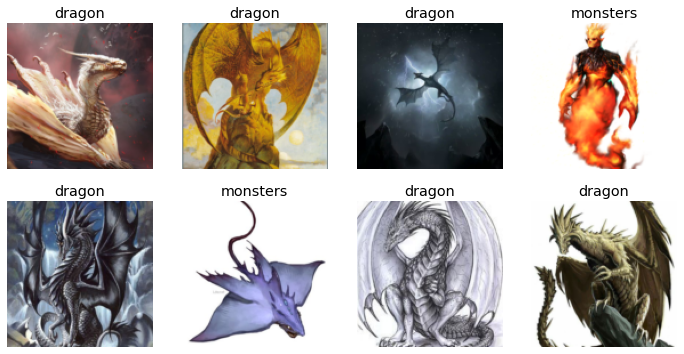

In [84]:
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = images.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

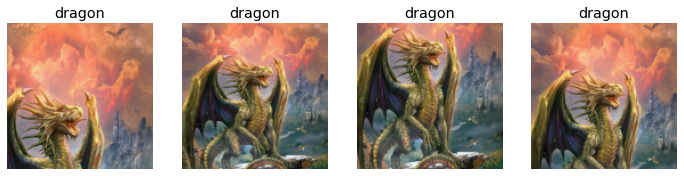

In [85]:
images = images.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = images.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [86]:
images = images.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = images.dataloaders(path)

In [87]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.062455,0.449265,0.216216,01:04


epoch,train_loss,valid_loss,error_rate,time
0,0.686671,0.355610,0.135135,01:13
1,0.593292,0.583424,0.243243,01:15
2,0.497367,0.556379,0.189189,01:18
3,0.433941,0.484872,0.189189,01:23


In [ ]:
# try with resnet50
learn2 = vision_learner(dls, resnet50, metrics=error_rate)
learn2.fine_tune(8)

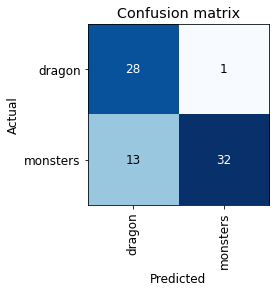

In [88]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

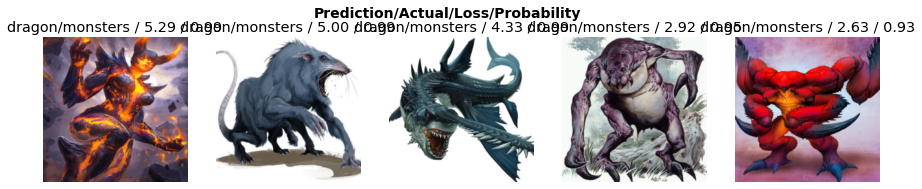

In [89]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn2)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Using the Model for Inference

In [90]:
learn.export()

In [91]:
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('export-resnet50.pkl'),Path('export.pkl')]

In [92]:
learn_inf = load_learner(path/'export.pkl')

In [95]:
learn_inf.predict('/content/train-images/monsters/pinterest_182395853646362973.jpg')

('monsters', TensorBase(1), TensorBase([0.1770, 0.8230]))

In [94]:
learn_inf.dls.vocab

['dragon', 'monsters']